# Import and filter data

### Import and get BGS data

In [1]:
from scipy.special import gammaln
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import healpy as hp
from astropy.io import fits
from astropy import conf
from astropy.table import Table, vstack, hstack, join
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
import numpy as np
import fitsio
import numpy.lib.recfunctions as rfn
import os
import pickle
import vast.catalog.void_catalog as void_catalog

cmap=matplotlib.colormaps['cool']

In [2]:
def get_bayes_factor(data_1, data_2, c = 1, max_depth=6, aj=lambda depth: depth**2, log_BF=False):
    """
    nonparamteric Bayes factors

    parameters:

    data_1 : arraylike
        Numpy array of data points sampled from the first distribution
    data_2 : arraylike
        Numpy array of data points sampled from the second distribution
    c : int 
        The tunable paramter c descibed in https://arxiv.org/abs/0910.5060v3
    max_depth : int
        The maximum depth of the partially specified Polya tree as described in https://arxiv.org/abs/0910.5060v3
        The Polya tree has a tree height of max_depth.
    aj : function
        The prescription for calculateing aj terms as a function of tree depth 
        as described in https://arxiv.org/abs/0910.5060v3
    log_BF: bool
        When False, the Bayes factor is returned, and when True, log10(Bayes factor) is returned
    """

    data_switch = len(data_1)
    combined_data = np.concatenate([data_1, data_2])
    del data_1, data_2

    # partition the data into quartiles
    quantiles = np.quantile(combined_data, np.linspace(0,1,2**max_depth + 1))

    # get the log bayes factor
    logbf = _get_bayes_factor(combined_data, data_switch, quantiles, low=0, high=1, c=c, depth=1, max_depth=max_depth, aj=aj)

    # return either the bayes factor or log bayes factor
    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def _get_bayes_factor(combined_data, data_switch, quantiles, low, high, c, depth, max_depth,aj):
    """
    helper function called by get_bayes_factor

    parameters:

    combined_data : arraylike
        Numpy array of data points sampled from the first and second distributions. 
        Data from the second distribution should follow after data from the first
    data_switch : int
        The array index seperating the two sampled distributions in combined_data
    low : float
        The low quantile for the current Polya tree node
    high : float
        The high quantile for the current Polya tree node
    c : int 
        The tunable paramter c descibed in https://arxiv.org/abs/0910.5060v3
    depth : int
        The depth of the current node in the Polya tree
    max_depth : int
        The maximum depth of the partially specified Polya tree as described in https://arxiv.org/abs/0910.5060v3
    aj : function
        The prescription for calculateing aj terms as a function of tree depth 
        as described in https://arxiv.org/abs/0910.5060v3
    
    """
    
    if depth > max_depth: 
        return 0

    # seelct quartiles
    low_q = quantiles[int((2**max_depth ) * low)]
    mid_q = quantiles[int((2**max_depth ) * (low+high)/2)]
    high_q = quantiles[int((2**max_depth ) * high)]

    # count data in quartiles
    if high == 1:
        data_1_low = np.count_nonzero((combined_data[:data_switch]>=low_q)*(combined_data[:data_switch]<=mid_q))
        data_2_low = np.count_nonzero((combined_data[data_switch:]>=low_q)*(combined_data[data_switch:]<=mid_q))
        data_1_high = np.count_nonzero((combined_data[:data_switch]>=mid_q)*(combined_data[:data_switch]<=high_q))
        data_2_high = np.count_nonzero((combined_data[data_switch:]>=mid_q)*(combined_data[data_switch:]<=high_q))
    else:
        data_1_low = np.count_nonzero((combined_data[:data_switch]>=low_q)*(combined_data[:data_switch]<mid_q))
        data_2_low = np.count_nonzero((combined_data[data_switch:]>=low_q)*(combined_data[data_switch:]<mid_q))
        data_1_high = np.count_nonzero((combined_data[:data_switch]>=mid_q)*(combined_data[:data_switch]<high_q))
        data_2_high = np.count_nonzero((combined_data[data_switch:]>=mid_q)*(combined_data[data_switch:]<high_q))

    # calculate the n_j terms for the current binnings
    data_1_n_j = [data_1_low, data_1_high]
    data_2_n_j = [data_2_low, data_2_high]

    # truncate the tree where there is no data
    if np.sum(data_1_n_j) == 0 or np.sum(data_2_n_j) == 0:
        return 0

    # calculate the a_j term for the current tree depth
    a_j = c * aj(depth)

    # calculate b_j

    log_gamma_summand_1 = 2 * gammaln(a_j) - gammaln(2 * a_j)
    log_gamma_summand_2 = gammaln(a_j + data_1_n_j[0] + data_2_n_j[0]) + gammaln(a_j + data_1_n_j[1] + data_2_n_j[1]) 
    log_gamma_summand_3 = - gammaln(2*a_j + data_1_n_j[0] + data_2_n_j[0] + data_1_n_j[1] + data_2_n_j[1])
    log_gamma_summand_4 = gammaln(2*a_j + data_1_n_j[0] + data_1_n_j[1]) + gammaln(2*a_j + data_2_n_j[0] + data_2_n_j[1])
    log_gamma_summand_5 = - gammaln(a_j + data_1_n_j[0]) - gammaln(a_j + data_2_n_j[0]) - gammaln(a_j + data_1_n_j[1]) - gammaln(a_j + data_2_n_j[1])

    log_b_j = log_gamma_summand_1 + log_gamma_summand_2 + log_gamma_summand_3 + log_gamma_summand_4 + log_gamma_summand_5

    # calculate the product of b_j terms on the left partition of the tree
    log_left_tree_b_j = _get_bayes_factor(combined_data, data_switch, quantiles, low, (low+high)/2, c, depth+1, max_depth, aj)

    # calculate the product of b_j terms on the right partition of the tree
    log_right_tree_b_j = _get_bayes_factor(combined_data, data_switch, quantiles, (low+high)/2, high, c, depth+1, max_depth, aj)

    # calculate the product of the b_j terms
    summed_b_j = log_b_j + log_left_tree_b_j + log_right_tree_b_j

    return summed_b_j


# Galaxy Environment Analysis

## Load galaxies

In [3]:
#gal_dir = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/galaxy_catalog/'

# Angular mask of 100% Survey Completeness
#mask_file = f"{gal_dir}/mask/loa_mask.fits"
#smoothed_mask_file = f"{gal_dir}/mask/loa_mask_smoothed.fits"

smoothed_mask_file = '/pscratch/sd/h/hrincon/loa_mask_smoothed.fits'


# Redshift limits
zmin = 0.
zmax = 0.24

# Read in mask
# There are two mask versions. The first ("mask") covers all regions of BGS that have been completed (for up to 4 passes).
# The second ("smoothed_mask") removes small non-contiguous regions from the mask for the purpose of void-finding on a contigious mask
# From now on, we will use "mask" to refer to "smoothed mask"
mask=fitsio.read(smoothed_mask_file)
#smoothed_mask=fitsio.read(smoothed_mask_file)
nside=hp.npix2nside(len(mask)) #healpix nside parameter

def get_spec_file_name (healpix_index):
    # Fastspec fit files are split up into different healpix groups that cover differnt regions of the sky
    # There are 12 files total
    formated_index = str(healpix_index).zfill(2)
    
    file_name = f'/global/cfs/cdirs/desi/vac/dr2/fastspecfit/loa/v1.0/catalogs/fastspec-loa-main-bright-nside1-hp{formated_index}.fits'

    return file_name

# Save information about the mask and masked galaxies


ngc_catalog = Table(names = ['TARGETID','RA','DEC','Z',
                          'ABSMAG01_SDSS_U','ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R', 'ABSMAG01_SDSS_Z',
                          'LOGMSTAR', 'SFR', 'HALPHA_EW'])

sgc_catalog = Table(names = ['TARGETID','RA','DEC','Z',
                          'ABSMAG01_SDSS_U','ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R', 'ABSMAG01_SDSS_Z',
                          'LOGMSTAR', 'SFR', 'HALPHA_EW'])

#Open the FastSpecFit VAC
for idx in range (12): #12 bgs files total
    
    with fitsio.FITS(get_spec_file_name(idx)) as full_catalog:

        
        print("reading data", idx)
        metadata = full_catalog[1]['TARGETID','Z','ZWARN','DELTACHI2','SPECTYPE','RA','DEC','BGS_TARGET', 'SURVEY', 'PROGRAM'
                           ][:]
        specphot = full_catalog[2][
                           'ABSMAG01_SDSS_U', 'ABSMAG01_SDSS_G',
                           'ABSMAG01_SDSS_R', 'ABSMAG01_SDSS_Z',
                           'LOGMSTAR', 'SFR', #'HALPHA_FLUX', 'HBETA_FLUX',
                          ][:]

        fastspec = full_catalog[3]['HALPHA_EW',][:]


        catalog = rfn.merge_arrays([metadata, specphot, fastspec], flatten=True, usemask=False)

        del metadata, specphot, fastspec

        print(len(catalog), "target observations read in")
        
        # Select BGS Bright galaxies
        select = np.where(
                   (catalog['SPECTYPE']=='GALAXY') 
                   & (catalog['SURVEY']=='main')
                   & (catalog['PROGRAM']=='bright')
                 )
        
        catalog=catalog[select]
            
        #check for duplicate targets
        _, select = np.unique(catalog['TARGETID'], return_index=True)
        if len(catalog) != len(select):
            raise ValueError(f'Duplicate galaxies detected. {len(select)} out of {len(catalog)} are unique')
                
        print(len(catalog), "bright time galaxies")
    
        # Impose redshift limits
        print("Imposing redshift limits")
        select = np.where((catalog['Z']>zmin)  # > zmin and not >=zmin to avoid galaxies at origin
                        & (catalog['Z']<=zmax) 
                     )

        catalog=catalog[select]
        
        print(len(catalog), "galaxies in redshift limits")
        
        # Cut on mask
        #The pixel IDs for every (ra, dec) position
        pxid=hp.ang2pix(nside, catalog['RA'], catalog['DEC'], nest=True,lonlat=True)
        #Select the galaxies that fall within the mask
        select = np.isin(pxid, mask[mask["DONE"]==1]["HPXPIXEL"])
        catalog=catalog[select]
        
        print(len(catalog), "galaxies within smoothed angular mask")
        
        #Quality cuts 
        #made to match Ross 2024, The Dark Energy Spectroscopic Instrument: Construction of Large-scale Structure Catalogs
        select = np.where(
                   (catalog['ZWARN']==0) 
                   & (catalog['DELTACHI2']>40) 
        )   
        
        catalog=catalog[select]
        
        print(len(catalog), "galaxies in final catalog")
        
        
        #split into NGC and SGC
        select = (catalog['RA'] < 304) * (catalog['RA'] > 83)

        print(len(catalog),'galaxies in NGC')
        print(len(catalog),'galaxies in SGC')
        
        #save catalog
        out=Table([catalog['TARGETID'],
                   catalog['RA'],
                   catalog['DEC'],
                   catalog['Z'],
                   catalog['BGS_TARGET'],
                   catalog['ABSMAG01_SDSS_U'],
                   catalog['ABSMAG01_SDSS_G'],
                   catalog['ABSMAG01_SDSS_R'],
                   catalog['ABSMAG01_SDSS_Z'],
                   catalog['LOGMSTAR'], 
                   catalog['SFR'], 
                   catalog["HALPHA_EW"]
                  ],
                   
                   names=['TARGETID','RA','DEC','Z', 'BGS_TARGET',
                          'ABSMAG01_SDSS_U','ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R', 'ABSMAG01_SDSS_Z',
                          'LOGMSTAR', 'SFR', 'HALPHA_EW']
                 )

        ngc_catalog = vstack([ngc_catalog, out[select]])
        sgc_catalog = vstack([sgc_catalog, out[~select]])

reading data 0
325494 target observations read in
320687 bright time galaxies
Imposing redshift limits
170304 galaxies in redshift limits
89741 galaxies within smoothed angular mask
88118 galaxies in final catalog
88118 galaxies in NGC
88118 galaxies in SGC
reading data 1
2693426 target observations read in
2645631 bright time galaxies
Imposing redshift limits
1387101 galaxies in redshift limits
1110544 galaxies within smoothed angular mask
1092159 galaxies in final catalog
1092159 galaxies in NGC
1092159 galaxies in SGC
reading data 2
3141532 target observations read in
3091103 bright time galaxies
Imposing redshift limits
1630922 galaxies in redshift limits
1470899 galaxies within smoothed angular mask
1443032 galaxies in final catalog
1443032 galaxies in NGC
1443032 galaxies in SGC
reading data 3
641198 target observations read in
632884 bright time galaxies
Imposing redshift limits
325361 galaxies in redshift limits
319738 galaxies within smoothed angular mask
312646 galaxies in fi

## Enter galaxies and voids into void catalog python class

In [4]:
voidfinder_voids_path_ngc = '/global/homes/j/jkneiss/DESIVAST_NGC_VoidFinder_Output.fits'
voidfinder_voids_path_sgc = '/global/homes/j/jkneiss/DESIVAST_SGC_VoidFinder_Output.fits'
voidfinder_catalog = void_catalog.VoidFinderCatalogStacked(['N','S'], [voidfinder_voids_path_ngc, voidfinder_voids_path_sgc])
voidfinder_catalog.add_galaxies(['tmp','tmp'], [ngc_catalog, sgc_catalog], 
                                [f'/global/homes/j/jkneiss/DR2_N_VF_vflag.fits', f'/global/homes/j/jkneiss/DR2_S_VF_vflag.fits'], 
                                redshift_name='Z', ra_name = 'RA', dec_name='DEC'
                               )

## Calculate galaxy environment flags 
### (this only needs to be done once before vflag FITS file are created)

In [5]:
#voidfinder_catalog.calculate_vflag([f'{gal_dir}/DR2_N_VF_vflag.fits', f'{gal_dir}/DR2_S_VF_vflag.fits'])

## Attach vflag info to galaxy catalogs

In [5]:
# VoidFinder
ngc_catalog['VF_FLAG'] = voidfinder_catalog['N'].galaxies['vflag']
sgc_catalog['VF_FLAG'] = voidfinder_catalog['S'].galaxies['vflag']

#Watershed algorithms (not investigated for now)
"""galaxy_table['VV_FLAG'] = 999
galaxy_table['VV_FLAG'][select_ngc] = vide_catalog['N'].galaxies['vflag']
galaxy_table['VV_FLAG'][~select_ngc] = vide_catalog['S'].galaxies['vflag']
galaxy_table['VR_FLAG'] = 999
galaxy_table['VR_FLAG'][select_ngc] = revolver_catalog['N'].galaxies['vflag']
galaxy_table['VR_FLAG'][~select_ngc] = revolver_catalog['S'].galaxies['vflag']""";

In [6]:
# provide arbitrary magnitude to galaxies so that they all pass the catalog magnitude cuts
voidfinder_catalog['N'].galaxies['rabsmag'] = - np.inf
voidfinder_catalog['S'].galaxies['rabsmag'] = - np.inf

## Cut out galaxies near the survey edges (low confidence in environmental classification)

In [7]:
# SGC edge cut
sgc_edge_cut = voidfinder_catalog['S'].galaxy_membership(return_selector=True)

In [8]:
# NGC edge cut
ngc_edge_cut = voidfinder_catalog['N'].galaxy_membership(return_selector=True)

In [9]:
# construct final galaxy table for analysis, using the edge cuts to remove edge galaxies
galaxy_table = vstack([ngc_catalog[ngc_edge_cut[0] + ngc_edge_cut[1]], sgc_catalog[sgc_edge_cut[0] + sgc_edge_cut[1]]])
del ngc_catalog, sgc_catalog

In [10]:
galaxy_table['ra'].name = 'RA'
galaxy_table['dec'].name = 'DEC'
galaxy_table['redshift'].name = 'Z'

## Define Functions 

In [ ]:

def get_property(prop_name, algorithm, environment, sample):
    """ 
    select galaxy property

    prop_name: name of property

    algorithm: name of void-finding algorithm

    environment: name of galaxy environment for selection (void, wall, or all)

    sample: DESI tracer used for selection

    """
    if environment == 'void':
        gals = galaxy_table[galaxy_table[f'{algorithm}_FLAG'] == 1]
    elif environment == 'wall':
        gals = galaxy_table[galaxy_table[f'{algorithm}_FLAG'] == 0]
    elif environment == 'all':
        gals = galaxy_table[(galaxy_table[f'{algorithm}_FLAG'] == 0) + (galaxy_table[f'{algorithm}_FLAG'] == 1)]
    else:
        raise ValueError('Invalid environment:', environment)

    if sample == 'BGS':
        gals = gals[(gals['BGS_TARGET'] & 2**1 != 0) + (gals['BGS_TARGET'] & 2**0 != 0)]
    elif sample == 'BGS Bright':
        gals = gals[(gals['BGS_TARGET'] & 2**1 != 0)]
    elif sample != "DR2":
        raise ValueError('Invalid sample:', sample)
        
    if prop_name.lower() in ['m_r', 'mr', 'rabsmag']:
        return gals['ABSMAG01_SDSS_R']
    elif prop_name.lower() in ['log_mstar', 'logmstar']:
        return gals['LOGMSTAR']
    elif prop_name.lower() in ['color_ur', 'ur', 'u-r']:
        return gals['ABSMAG01_SDSS_U'] - gals['ABSMAG01_SDSS_R']
    elif prop_name.lower() in ['color_gr', 'gr', 'g-r']:
        return gals['ABSMAG01_SDSS_G'] - gals['ABSMAG01_SDSS_R']
        
    elif prop_name.lower() in ['halpha', 'halpha_ew']:
        return gals['HALPHA_EW']
    elif prop_name.lower() in ['log_halpha', 'log_halpha_ew']:
        halpha = np.full(len(gals), -np.inf)
        halpha[gals['HALPHA_EW']>0] = np.log10(gals['HALPHA_EW'][gals['HALPHA_EW']>0])
        return halpha
    elif prop_name.lower() == 'sfr':
        return gals['SFR']
    elif prop_name.lower() in ['z', 'redshift']:
        return gals['Z']
    #elif prop_name.lower() == '':
    #    return gals['']
    else:
        raise ValueError('Invalid Property:'+prop_name)

In [12]:
def get_mr_z_bin(redshift, zmin, zmax, mr, mrmin, mrmax, galaxy_property, prop_name):

    select = (redshift < zmax) * (redshift > zmin) * (mr < mrmax) * (mr > mrmin)
    if prop_name == 'halpha':
        galaxy_property=galaxy_property[select]
        galaxy_property = galaxy_property[galaxy_property>0]
        prop = np.log10(galaxy_property)
        prop = prop[(prop>-3)*(prop<5)]
        return prop
    return galaxy_property[select]

In [15]:
def get_redshift_bins(prop_name, num_z_bins=7, algorithm='VF', sample='BGS Bright'):
    """
    Create redshift bins for void and wall galaxies, returning the data
    needed for Bayes factor analysis (no plotting).

    Parameters
    ----------
    prop_name : str
        Galaxy property to compare (e.g., 'halpha', 'sfr', 'logmstar').
    num_z_bins : int, optional
        Number of redshift bins to create (default=7).
    algorithm : str, optional
        Name of void-finding algorithm (default='VF').
    sample : str, optional
        Galaxy sample (default='BGS Bright').

    Returns
    -------
    bins : list of dict
        Each dictionary contains:
        {
            'zmin', 'zmax',
            'void_bin', 'wall_bin'
        }
    """

    # Get galaxy properties and redshifts
    void_property = get_property(prop_name, algorithm, 'void', sample)
    wall_property = get_property(prop_name, algorithm, 'wall', sample)

    if prop_name == 'halpha':
        void_property=void_property[np.isfinite(void_property)]
        wall_property=wall_property[np.isfinite(wall_property)]

    void_redshift = get_property('z', algorithm, 'void', sample)
    wall_redshift = get_property('z', algorithm, 'wall', sample)

    bins = []

    # Define redshift bin edges based on combined distribution
    combined_z = np.concatenate([void_redshift, wall_redshift])
    valid_z = combined_z[np.isfinite(combined_z)]
    z_bins = np.quantile(valid_z, np.linspace(0, 1, num_z_bins))

    # Loop over redshift bins
    for zmin, zmax in zip(z_bins[:-1], z_bins[1:]):
        # Select galaxies in this redshift range
        void_mask = (void_redshift > zmin) & (void_redshift <= zmax)
        wall_mask = (wall_redshift > zmin) & (wall_redshift <= zmax)

        void_bin = void_property[void_mask]
        wall_bin = wall_property[wall_mask]

        # Skip empty bins
        if len(void_bin) == 0 or len(wall_bin) == 0:
            continue

        # Downsample the larger population to equal sample sizes
        min_len = min(len(void_bin), len(wall_bin))
        np.random.seed(0)
        void_bin = np.random.choice(void_bin, min_len, replace=False)
        wall_bin = np.random.choice(wall_bin, min_len, replace=False)

        # Store bin info
        bins.append({
            'zmin': zmin,
            'zmax': zmax,
            'void_bin': void_bin,
            'wall_bin': wall_bin
        })

    return bins

In [13]:
def plot_bayes_factors (sample, variable, algorithm, max_depth_iter):
    
    for i, c in enumerate(range(1,10)):
        rgba = cmap(i/10)
    
        depth_array = np.arange(1,max_depth_iter)
        log_bayes_factors = np.zeros_like(depth_array)
        for i, depth in enumerate(depth_array):
            
            log_bayes_factors[i] = bf_variable = get_bayes_factor(get_property(variable, algorithm, 'wall', sample), 
                                 get_property(variable, algorithm, 'void', sample), 
                                 max_depth=depth, c=c, log_BF=True)
        plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
    plt.legend()
    plt.xlabel('max depth')
    plt.ylabel('log(Bayes factor)')
    plt.title('Change in Bayes factor as c and max depth changes for '+str(variable));
    return plt.show()

## Create Bayes Factor Plots

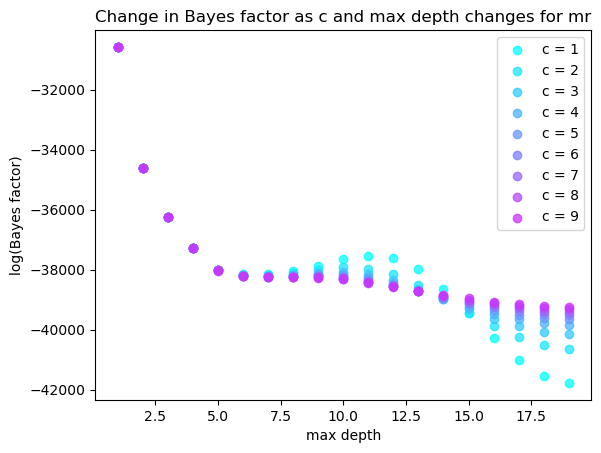

In [ ]:
for variable in ['mr','log_mstar','u-r','g-r']:
    plot_bayes_factors ('BGS Bright', variable, 'VF', 20)

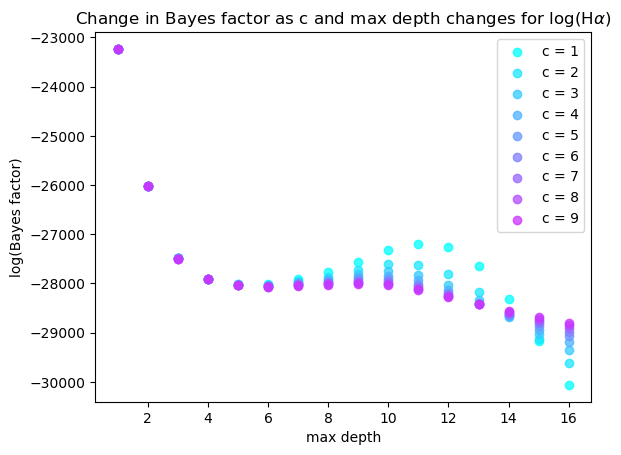

In [37]:
#For Halpha graph
wall_Ha = get_property('log_halpha', 'VF', 'wall', 'BGS Bright')
wall_Ha = wall_Ha[np.isfinite(wall_Ha)]
void_Ha = get_property('log_halpha', 'VF', 'void', 'BGS Bright')
void_Ha = void_Ha[np.isfinite(void_Ha)]
for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)

    depth_array = np.arange(1,17)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):

        log_bayes_factors[i] = bf_halpha = get_bayes_factor(wall_Ha, 
                                 void_Ha, 
                                 max_depth=depth, c=c, log_BF=True)
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title(r'Change in Bayes factor as c and max depth changes for log(H$\alpha$)');
plt.show()

In [17]:
def plot_single_bin_bayes_factor(bin_data, variable, max_depth_iter=14):

    """
    See how Bayes factor varies with max depth and c for redshift cuts
    """

    cmap = matplotlib.colormaps['cool']

    for i, c in enumerate(range(1, 10, 2)):
        rgba = cmap(2*i / 10)
        depth_array = np.arange(1, max_depth_iter + 1)
        log_bf_array = np.zeros_like(depth_array, dtype=float)

        for j, depth in enumerate(depth_array):
            log_bf_array[j] = get_bayes_factor(
                bin_data["wall_bin"], 
                bin_data["void_bin"], 
                max_depth=depth, 
                c=c, 
                log_BF=True
            )

        plt.scatter(depth_array, log_bf_array, color=rgba, alpha=0.8, label=f"c={c}")

    plt.xlabel("max depth")
    plt.ylabel("log(Bayes Factor)")

    # Compute total number of galaxies in this bin
    total_galaxies = len(bin_data["wall_bin"]) + len(bin_data["void_bin"])

    plt.title(
        f"Bayes Factor change with max depth and c ({variable})\n"
        f"z=[{bin_data['zmin']:.03f},{bin_data['zmax']:.03f}], "
        f"total galaxies={total_galaxies:.5g}"
    )
    plt.grid(True, alpha=0.3)
    plt.show()

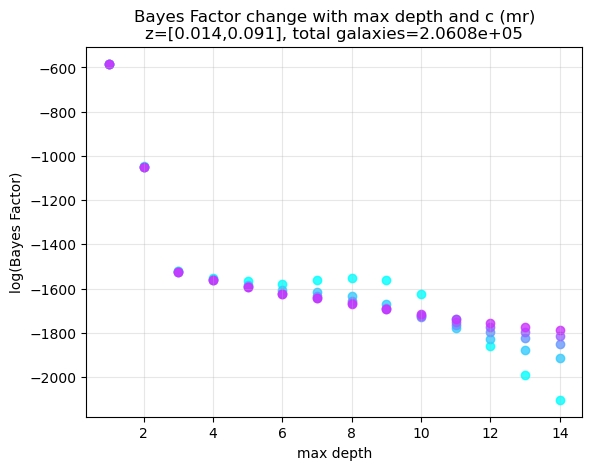

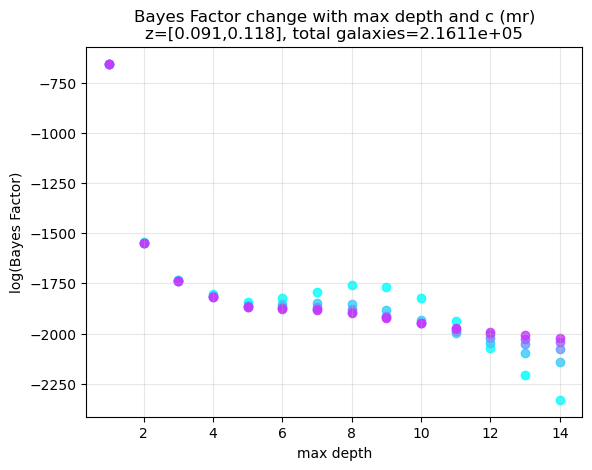

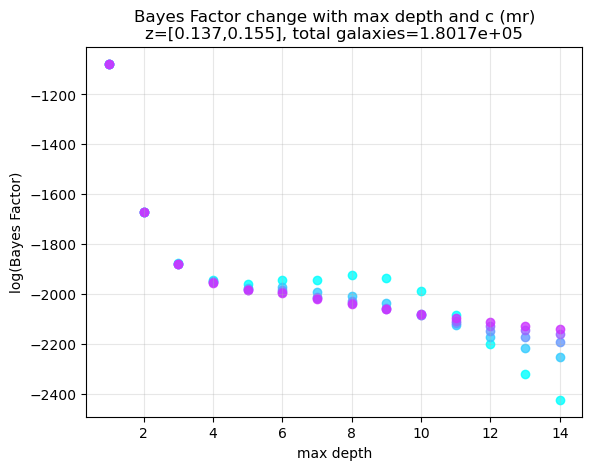

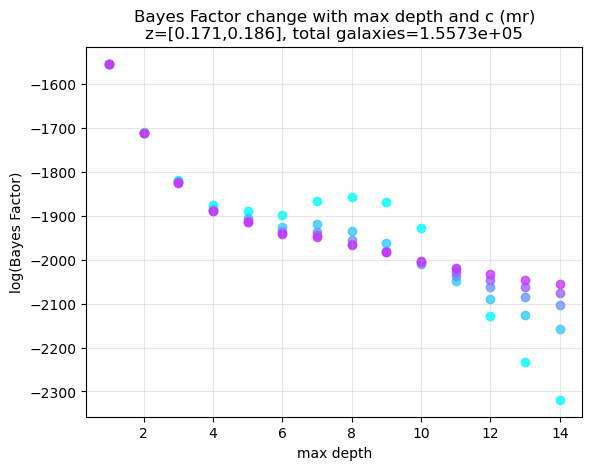

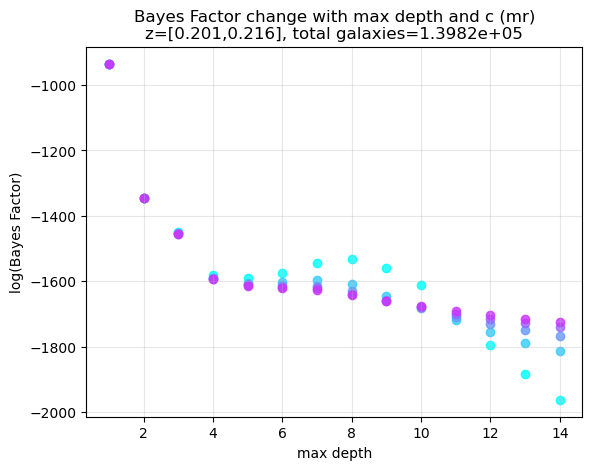

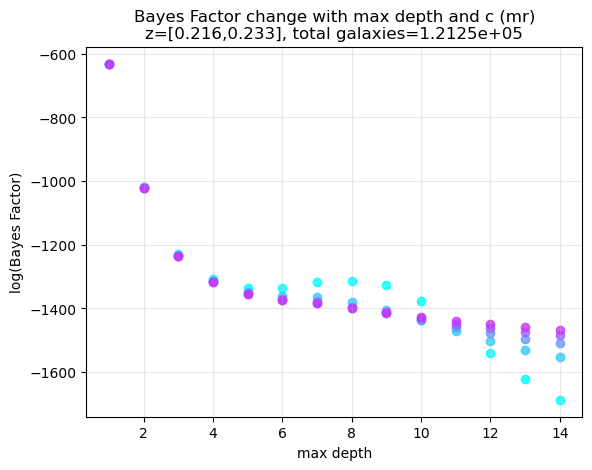

In [18]:
bins=get_redshift_bins('mr', num_z_bins=10)

for i in [0,1,3,5,7,8]:
    plot_single_bin_bayes_factor(bins[i], 'mr', max_depth_iter=14)

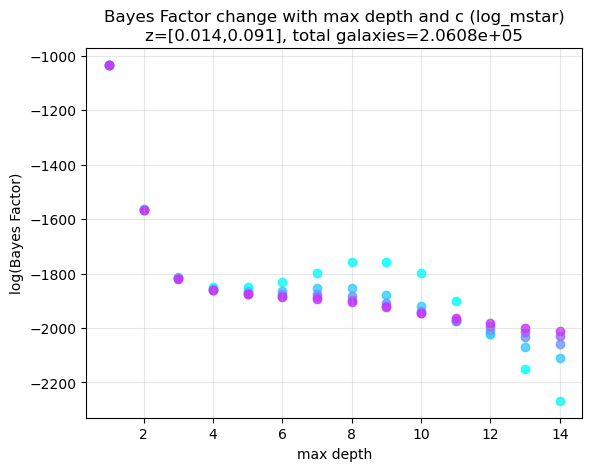

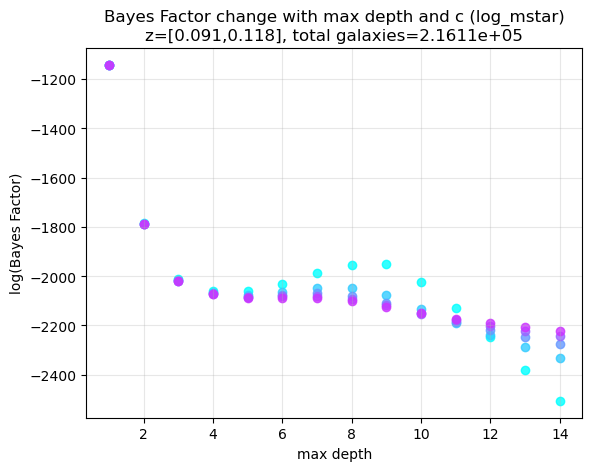

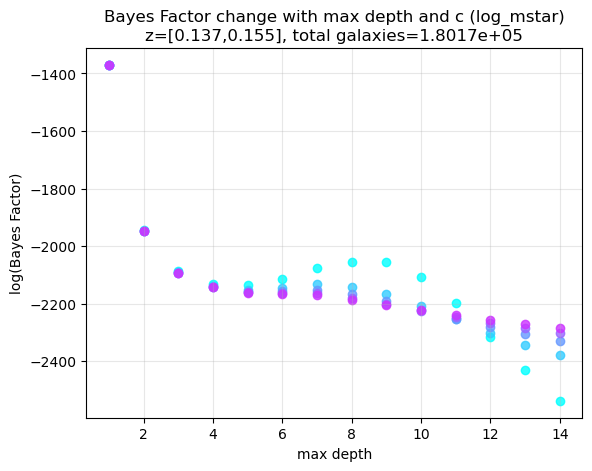

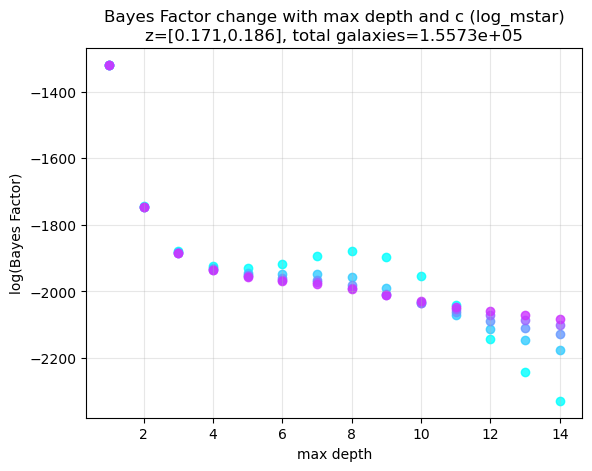

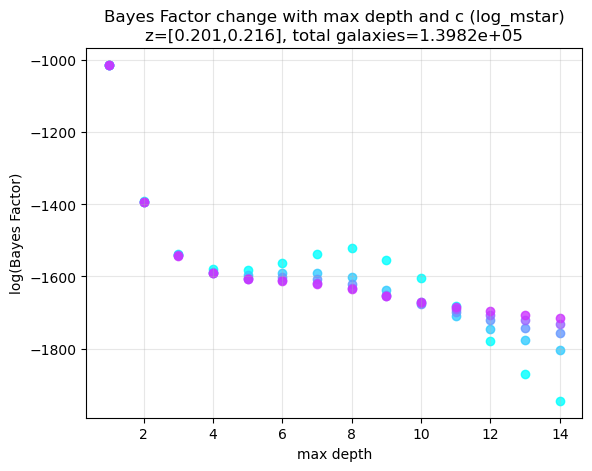

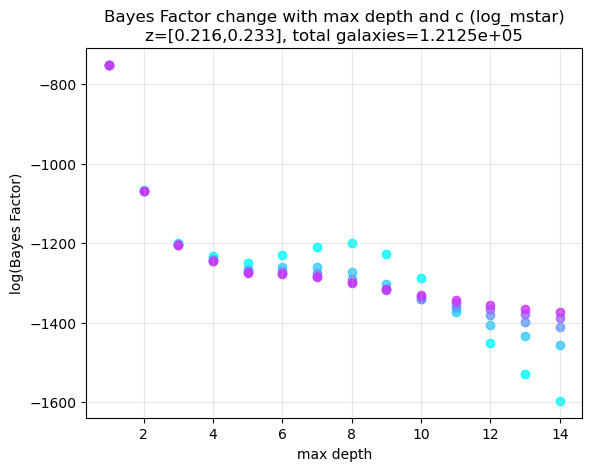

In [23]:
bins=get_redshift_bins('log_mstar', num_z_bins=10)

for i in [0,1,3,5,7,8]:
    plot_single_bin_bayes_factor(bins[i], 'log_mstar', max_depth_iter=14)

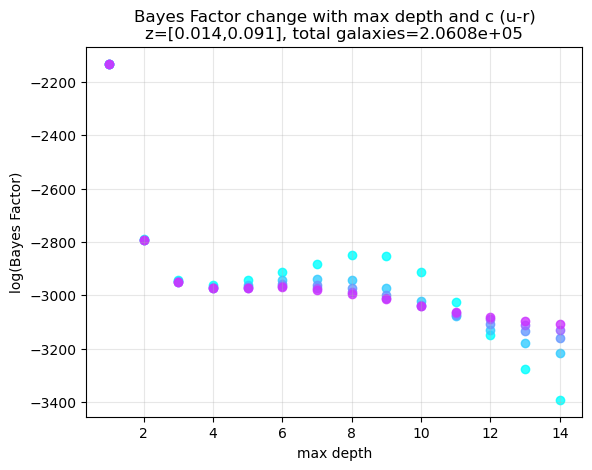

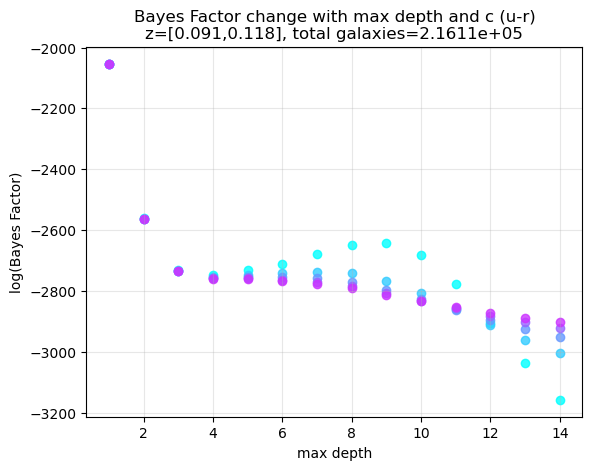

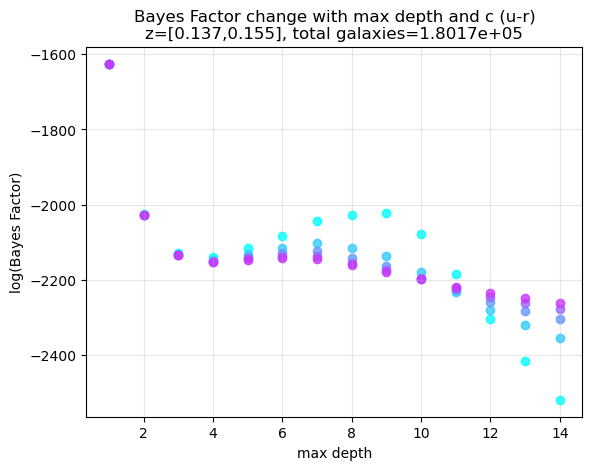

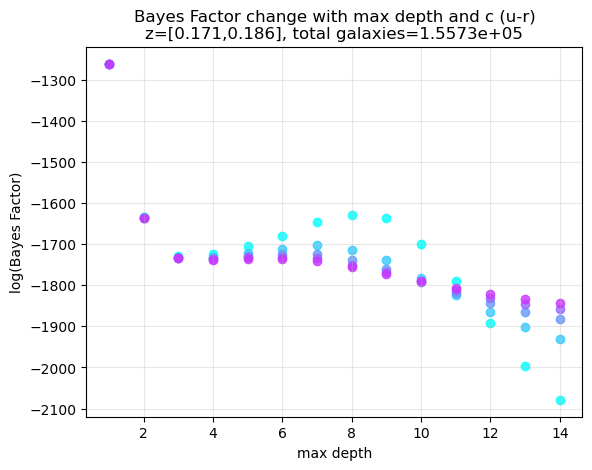

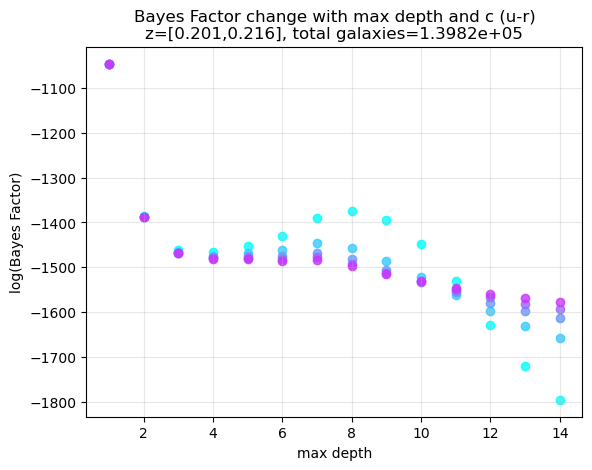

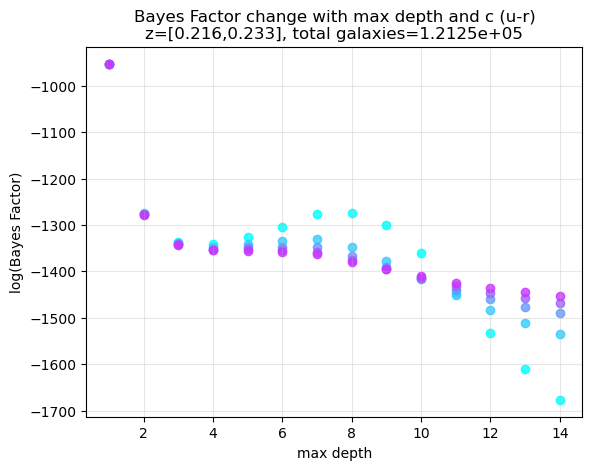

In [24]:
bins=get_redshift_bins('u-r', num_z_bins=10)

for i in [0,1,3,5,7,8]:
    plot_single_bin_bayes_factor(bins[i], 'u-r', max_depth_iter=14)

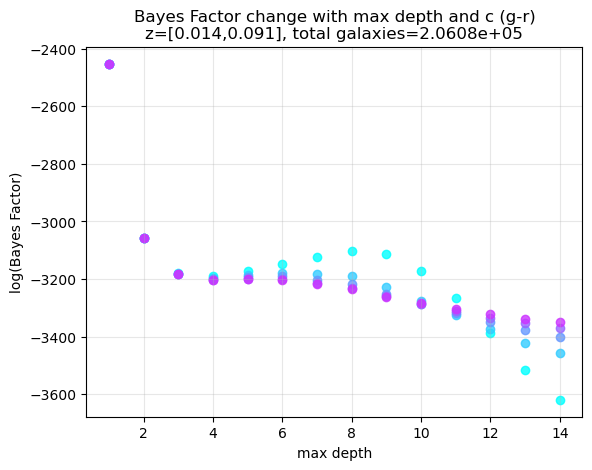

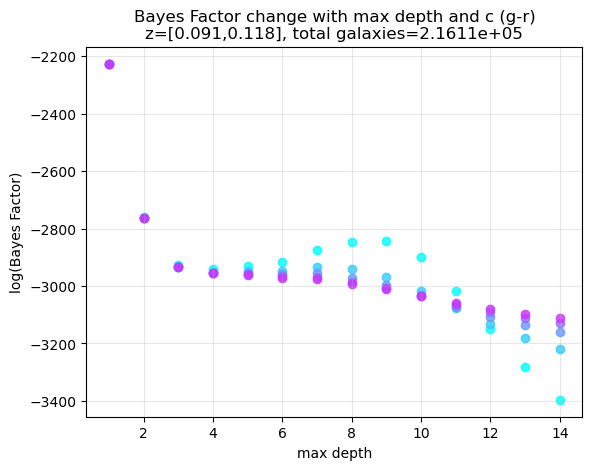

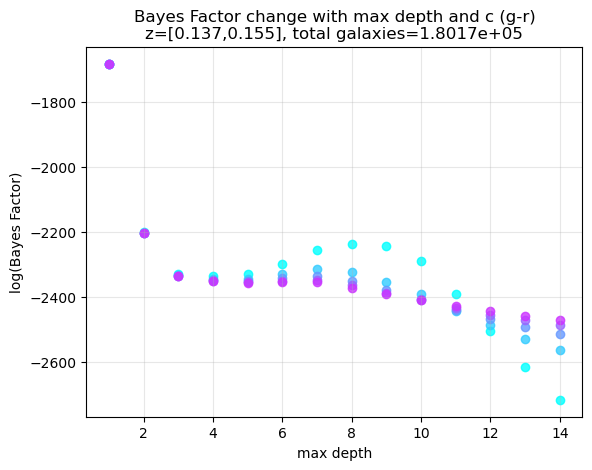

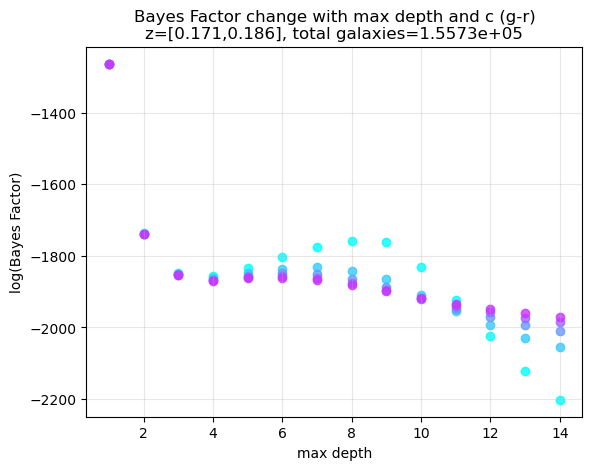

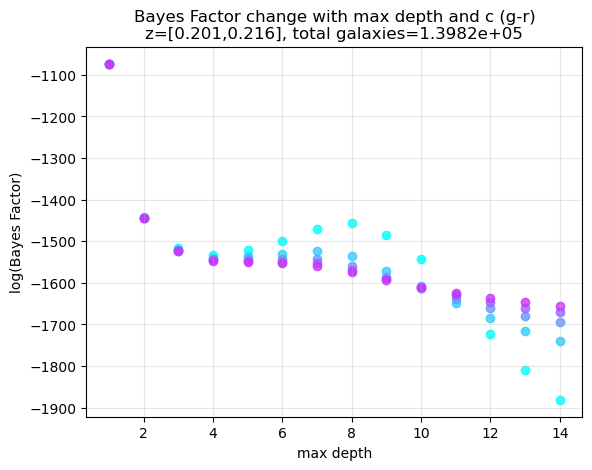

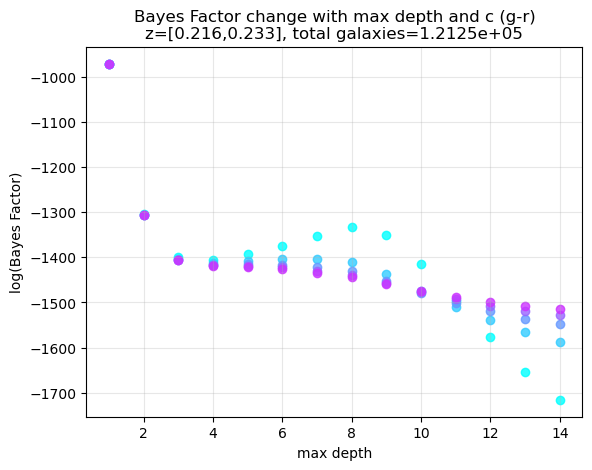

In [25]:
bins=get_redshift_bins('g-r', num_z_bins=10)

for i in [0,1,3,5,7,8]:
    plot_single_bin_bayes_factor(bins[i], 'g-r', max_depth_iter=14)